In [3]:
!pip uninstall -y apache-beam chex momepy pymc3 ydata-profiling
!pip install numpy==1.23.5


In [4]:
!pip install transformers

# CSIC-2010 DATASET
 The dataset contains the generated traffic targeted to an e-commerce web
application. It is an automatically generated dataset that contains 36,000 normal
requests and more than 25,000 anomalous requests (i.e., web attacks).

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import math
import eli5

#dataset pre-processing realated imports
import sklearn
from eli5.sklearn import PermutationImportance
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#imports related to classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

#DNN imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Explainability imports
from sklearn.inspection import PartialDependenceDisplay




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print('Done!')

/kaggle/input/csic-2010-web-application-attacks/csic_database.csv
Done!


**READ CSV**

In [7]:
csic_filepath='/kaggle/input/csic-2010-web-application-attacks/csic_database.csv'
csic_data=pd.read_csv(csic_filepath)
print('Done!')

Done!


In [8]:
n_features=csic_data.shape[1]
n_samples =csic_data.shape[0]


print("Number of samples:", n_samples)
print("Number of features:", n_features)




Number of samples: 61065
Number of features: 17


In [9]:
# csic_data.head()

In [10]:
csic_data.tail()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
61060,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61061,Anomalous,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,application/x-www-form-urlencoded,Connection: close,Content-Length: 255,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....
61062,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/miembros/editar....
61063,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...
61064,Anomalous,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=3CC12010CDA952F123240EBAD79B55CC,NaN,close,NaN,NaN,1,http://localhost:8080/tienda1/imagenes/nuestra...


In [11]:
csic_data.columns



Index(['Unnamed: 0', 'Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content',
       'classification', 'URL'],
      dtype='object')

# **Data Visualization**

<Axes: xlabel='Unnamed: 0', ylabel='count'>

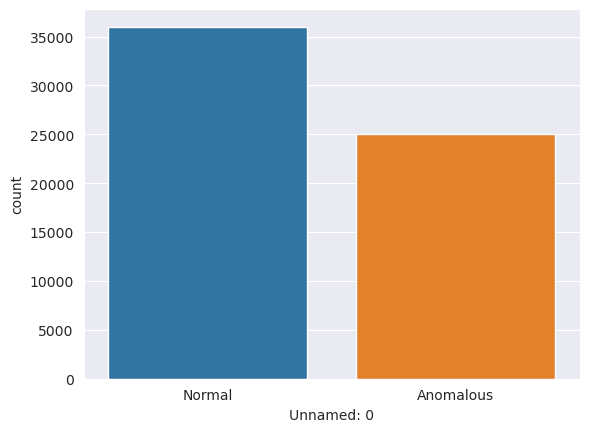

In [12]:
sns.set_style('darkgrid')
sns.countplot(data=csic_data, x='Unnamed: 0')

Dropping samples with at least 1 NaN value will make to lose all the other Request Methods besides POST, this option is discarded since dropping data is not usually a good choice

In [13]:
csic_data.head()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


Visualizing URL format

In [14]:
feature_names=[ 'Unnamed: 0','Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content','classification',
        'URL']

X=csic_data[feature_names]
print(X)

      Unnamed: 0 Method                                         User-Agent  \
0         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
1         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
2         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
3         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
4         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
...          ...    ...                                                ...   
61060  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61061  Anomalous   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61062  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61063  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61064  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   

         Pragma Cache-Control  \
0      no-cache      no-cache 

# **Removing not discriminatory features**

**Enumerating unique values for each feature**

In [15]:
# Removing not discriminatory Features and making some adjustments on feature names
X = X.rename(columns={'Unnamed: 0': 'Class'})
X = X.rename(columns={'lenght': 'content_length'})


feature_names=[ 'Class','Method','host','cookie','Accept', 'content_length', 'content','classification','URL']

# Print the remaining data
X = X[feature_names]
print(X)

           Class Method            host  \
0         Normal    GET  localhost:8080   
1         Normal    GET  localhost:8080   
2         Normal   POST  localhost:8080   
3         Normal    GET  localhost:8080   
4         Normal   POST  localhost:8080   
...          ...    ...             ...   
61060  Anomalous    GET  localhost:8080   
61061  Anomalous   POST  localhost:8080   
61062  Anomalous    GET  localhost:8080   
61063  Anomalous    GET  localhost:8080   
61064  Anomalous    GET  localhost:8080   

                                            cookie  \
0      JSESSIONID=1F767F17239C9B670A39E9B10C3825F4   
1      JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5   
2      JSESSIONID=933185092E0B668B90676E0A2B0767AF   
3      JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0   
4      JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2   
...                                            ...   
61060  JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275   
61061  JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3 

In [16]:
y=X.Class
print(y)


0           Normal
1           Normal
2           Normal
3           Normal
4           Normal
           ...    
61060    Anomalous
61061    Anomalous
61062    Anomalous
61063    Anomalous
61064    Anomalous
Name: Class, Length: 61065, dtype: object


In [17]:
size=X.shape[1]
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length', 'content', 'URL']


Load Models

# **Pre-processing on the feature: Content Length**

In [18]:
print(X.content_length)

0                        NaN
1                        NaN
2         Content-Length: 68
3                        NaN
4         Content-Length: 63
                ...         
61060                    NaN
61061    Content-Length: 255
61062                    NaN
61063                    NaN
61064                    NaN
Name: content_length, Length: 61065, dtype: object


Operations on the 'content_lenght' feature

In [19]:
#replace NaN values with 0
#removing the 'Content-Lenght' string and keeping only the numerical value

X['content_length'] = X['content_length'].astype(str)
X['content_length'] = X['content_length'].str.extract(r'(\d+)')
X['content_length'] = pd.to_numeric(X['content_length'], errors='coerce').fillna(0)
print(X.content_length)


0          0.0
1          0.0
2         68.0
3          0.0
4         63.0
         ...  
61060      0.0
61061    255.0
61062      0.0
61063      0.0
61064      0.0
Name: content_length, Length: 61065, dtype: float64


GET methods have the content_length set to 0 since they where all NaN (this method does not have to provide content)

In [20]:
filtered_length = X.loc[X['Method'] == 'GET', 'content_length']
print(filtered_length)


0        0.0
1        0.0
3        0.0
5        0.0
7        0.0
        ... 
61058    0.0
61060    0.0
61062    0.0
61063    0.0
61064    0.0
Name: content_length, Length: 43088, dtype: float64


# URL PRE-PROCESSING

In [21]:
url_counts = X['URL'].value_counts()
most_common_urls = url_counts.head(10)  # Extract the top 10 most common strings

print("Most common URLs:")
for i, (url, count) in enumerate(most_common_urls.items(), 1):
    print(f"{i}. URL: {url} - Count: {count}")


Most common URLs:
1. URL: http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1 - Count: 2441
2. URL: http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1 - Count: 2422
3. URL: http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 - Count: 2417
4. URL: http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1 - Count: 2412
5. URL: http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1 - Count: 2379
6. URL: http://localhost:8080/tienda1/publico/caracteristicas.jsp HTTP/1.1 - Count: 2003
7. URL: http://localhost:8080/tienda1/publico/vaciar.jsp HTTP/1.1 - Count: 1965
8. URL: http://localhost:8080/tienda1/publico/entrar.jsp HTTP/1.1 - Count: 1938
9. URL: http://localhost:8080/tienda1/index.jsp HTTP/1.1 - Count: 1000
10. URL: http://localhost:8080/tienda1/miembros/salir.jsp HTTP/1.1 - Count: 1000


**Utils for URL/Content pre-processing**

In [22]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')


def count_equal(url):
    return url.count('=')


def url_length(url):
    return len(str(url))

#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)


import re

def suspicious_words(url):
    score_map = {
        'error': 30,
        'errorMsg': 30,
        'id': 10,
        'errorID': 30,
        'SELECT': 50,
        'FROM': 50,
        'WHERE': 50,
        'DELETE': 50,
        'USERS': 50,
        'DROP': 50,
        'CREATE': 50,
        'INJECTED': 50,
        'TABLE': 50,
        'alert': 30,
        'javascript': 20,
        'cookie': 25,
        '--': 30,
        '.exe': 30,
        '.php': 20,
        '.js': 10,
        'admin': 10,
        'administrator': 10,
        '\'': 30,
        'password': 15,
        'login': 15,
        'incorrect': 20,
        'pwd': 15,
        'tamper': 25,
        'vaciar': 20,
        'carrito': 25,
        'wait': 30,
        'delay': 35,
        'set': 20,
        'steal': 35,
        'hacker': 35,
        'proxy': 35,
        'location': 30,
        'document.cookie': 40,
        'document': 20,
        'set-cookie': 40,
        'create': 40,
        'cmd': 40,
        'dir': 30,
        'shell': 40,
        'reverse': 30,
        'bin': 20,
        'cookiesteal': 40,
        'LIKE': 30,
        'UNION': 35,
        'include': 30,
        'file': 20,
        'tmp': 25,
        'ssh': 40,
        'exec': 30,
        'cat': 25,
        'etc': 30,
        'fetch': 25,
        'eval': 30,
        'wait': 30,
        'malware': 45,
        'ransomware': 45,
        'phishing': 45,
        'exploit': 45,
        'virus': 45,
        'trojan': 45,
        'backdoor': 45,
        'spyware': 45,
        'rootkit': 45,
        'credential': 30,
        'inject': 30,
        'script': 25,
        'iframe': 25,
        'src=': 25,
        'onerror': 30,
        'prompt': 20,
        'confirm': 20,
        'eval': 25,
        'expression': 30,
        'function\(': 20,
        'xmlhttprequest': 30,
        'xhr': 20,
        'window.': 20,
        'document.': 20,
        'cookie': 25,
        'click': 15,
        'mouseover': 15,
        'onload': 20,
        'onunload': 20,
    }

    matches = re.findall(r'(?i)' + '|'.join(score_map.keys()), url)

    total_score = sum(score_map.get(match.lower(), 0) for match in matches)
    return total_score


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

def count_special_characters(url):
    special_characters = re.sub(r'[a-zA-Z0-9\s]', '', url)
    count = len(special_characters)
    return count


# Number of Parameters in URL
def number_of_parameters(url):
    params = urlparse(url).query
    return 0 if params == '' else len(params.split('&'))

# Number of Fragments in URL
def number_of_fragments(url):
    frags = urlparse(url).fragment
    return len(frags.split('#')) - 1 if frags == '' else 0

# URL is Encoded
def is_encoded(url):
    return int('%' in url.lower())


def unusual_character_ratio(url):
    total_characters = len(url)
    unusual_characters = re.sub(r'[a-zA-Z0-9\s\-._]', '', url)
    unusual_count = len(unusual_characters)
    ratio = unusual_count / total_characters if total_characters > 0 else 0
    return ratio



In [23]:
X['count_dot_url'] = X['URL'].apply(count_dot)
X['count_dir_url'] = X['URL'].apply(no_of_dir)
X['count_embed_domain_url'] = X['URL'].apply(no_of_embed)
X['short_url'] = X['URL'].apply(shortening_service)
X['count-http'] = X['URL'].apply(count_http)
X['count%_url'] = X['URL'].apply(count_per)
X['count?_url'] = X['URL'].apply(count_ques)
X['count-_url'] = X['URL'].apply(count_hyphen)
X['count=_url'] = X['URL'].apply(count_equal)
X['hostname_length_url'] = X['URL'].apply(hostname_length)
X['sus_url'] = X['URL'].apply(suspicious_words)
X['count-digits_url'] = X['URL'].apply(digit_count)
X['count-letters_url'] = X['URL'].apply(letter_count)
X['url_length'] = X['URL'].apply(url_length)
X['number_of_parameters_url'] = X['URL'].apply(number_of_parameters)
X['number_of_fragments_url'] = X['URL'].apply(number_of_fragments)
X['is_encoded_url'] = X['URL'].apply(is_encoded)
X['special_count_url'] = X['URL'].apply(count_special_characters)
X['unusual_character_ratio_url'] = X['URL'].apply(unusual_character_ratio)



In [24]:
# Select the features and class variable for plotting
new_features = ['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'number_of_fragments_url', 'is_encoded_url','special_count_url','unusual_character_ratio_url']

# Create a DataFrame with the selected features
set = X[new_features]

for new_feature in X.columns:
    if new_feature in X.columns:
        unique_count = X[new_feature].nunique()
        print(f"Number of unique values for {new_feature}: {unique_count}")
    else:
        print(f"Column '{new_feature}' does not exist in the DataFrame.")



Number of unique values for Class: 2
Number of unique values for Method: 3
Number of unique values for host: 2
Number of unique values for cookie: 61065
Number of unique values for Accept: 1
Number of unique values for content_length: 383
Number of unique values for content: 12091
Number of unique values for classification: 2
Number of unique values for URL: 13498
Number of unique values for count_dot_url: 9
Number of unique values for count_dir_url: 7
Number of unique values for count_embed_domain_url: 2
Number of unique values for short_url: 2
Number of unique values for count-http: 2
Number of unique values for count%_url: 34
Number of unique values for count?_url: 2
Number of unique values for count-_url: 8
Number of unique values for count=_url: 5
Number of unique values for hostname_length_url: 5
Number of unique values for sus_url: 61
Number of unique values for count-digits_url: 112
Number of unique values for count-letters_url: 259
Number of unique values for url_length: 417
N

# Removing Cookies as feature
 **cookies are unique for each sample, this feature cannot be used as discriminant**

In [25]:
unique_count = X['cookie'].nunique()
print(f"Count of unique values in 'cookie': {unique_count}")


Count of unique values in 'cookie': 61065


# Encoding categorical features

In [26]:
X['Accept'] = X['Accept'].astype(str)
X['Accept'] = X['Accept'].str.extract(r'(\d+)')
X['Accept'] = pd.to_numeric(X['Accept'], errors='coerce').fillna(1)

In [27]:
lb_make = LabelEncoder()
X["Method_enc"] = lb_make.fit_transform(X["Method"])
X["host_enc"] =lb_make.fit_transform(X["host"])
X["Accept_enc"] =lb_make.fit_transform(X["Accept"])


In [28]:
X.head(10)

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,0.0,0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,31,48,0,0,0,9,0.145833,0,0,0
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,86,126,5,0,1,24,0.174603,0,0,0
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,0.0,68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,39,57,0,0,0,10,0.140351,1,0,0
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,92,125,5,0,1,21,0.152000,0,0,0
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,0.0,63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,43,61,0,0,0,10,0.131148,1,0,0
5,Normal,GET,localhost:8080,JSESSIONID=5254A7A7C7F0E74D699E6A9C9487795A,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/caracter...,2,...,50,71,1,0,0,12,0.140845,0,0,0
6,Normal,POST,localhost:8080,JSESSIONID=417DBC69B2F909CCD574CFC69F56779F,0.0,4.0,id=2,0,http://localhost:8080/tienda1/publico/caracter...,2,...,48,66,0,0,0,10,0.121212,1,0,0
7,Normal,GET,localhost:8080,JSESSIONID=42B53DB3F82E67BBB24E57E9CDC8E008,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/carrito....,2,...,40,58,0,0,0,10,0.137931,0,0,0
8,Normal,GET,localhost:8080,JSESSIONID=A651CE9798E1B71FCA9D9B2159432A22,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/entrar.j...,2,...,70,91,1,0,0,13,0.120879,0,0,0
9,Normal,POST,localhost:8080,JSESSIONID=EE6A06EE8174FC2B05432AA5A0FCE998,0.0,33.0,errorMsg=Credenciales+incorrectas,0,http://localhost:8080/tienda1/publico/entrar.j...,2,...,39,57,0,0,0,10,0.140351,1,0,0


In [29]:
unique_count_met = X["Method_enc"].nunique()
unique_count_host = X["host_enc"].nunique()
unique_count_acc = X["Accept_enc"].nunique()


print(f"Number of unique values for 'Method_enc': {unique_count_met}")
print(f"Number of unique values for 'host_enc': {unique_count_host}")
print(f"Number of unique values for 'Accept_enc': {unique_count_acc}")





Number of unique values for 'Method_enc': 3
Number of unique values for 'host_enc': 2
Number of unique values for 'Accept_enc': 2


In [30]:
X.head()



,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,0.0,0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,31,48,0,0,0,9,0.145833,0,0,0
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,86,126,5,0,1,24,0.174603,0,0,0
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,0.0,68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,39,57,0,0,0,10,0.140351,1,0,0
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,92,125,5,0,1,21,0.152000,0,0,0
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,0.0,63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,43,61,0,0,0,10,0.131148,1,0,0


In [31]:
X.tail()

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,218,314,13,0,1,48,0.143312,0,0,0
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,0.0,255.0,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,2,...,40,58,0,0,0,10,0.137931,1,0,0
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,43,62,0,0,0,11,0.129032,0,0,0
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,2,...,34,54,0,0,0,11,0.166667,0,0,0
61064,Anomalous,GET,localhost:8080,JSESSIONID=3CC12010CDA952F123240EBAD79B55CC,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/nuestra...,3,...,50,69,0,0,0,11,0.115942,0,0,0


In [32]:
def apply_to_content(content,function):
    if pd.isna(content):
        return 0
    elif isinstance(content, str):
        return function(content)

#"""
#                'count_dot_content','count_dir_content','count_embed_domain_content','count%_content','count?_content',
 #               'count-_content','count=_content','hostname_length_content','sus_content','count_digits_content',
  #              'count_letters_content','content_length','number_of_parameters_content','number_of_fragments_content',
   #             'is_encoded_content','special_count_content','unusual_character_ratio_content'
    #            ]"""

X['count_dot_content'] = X['content'].apply(apply_to_content, function=count_dot)
X['count_dir_content'] = X['content'].apply(apply_to_content, function=no_of_dir)
X['count_embed_domain_content'] = X['content'].apply(apply_to_content, function=no_of_embed)
X['count%_content'] = X['content'].apply(apply_to_content, function=count_per)
X['count?_content'] = X['content'].apply(apply_to_content, function=count_ques)
X['count-_content'] = X['content'].apply(apply_to_content, function=count_hyphen)
X['count=_content'] = X['content'].apply(apply_to_content, function=count_equal)
X['content_length'] = X['content'].apply(apply_to_content, function=url_length)
X['sus_content'] = X['content'].apply(apply_to_content, function=suspicious_words)
X['count_digits_content'] = X['content'].apply(apply_to_content, function=digit_count)
X['count_letters_content'] = X['content'].apply(apply_to_content, function=letter_count)
X['special_count_content'] = X['content'].apply(apply_to_content, function=count_special_characters)
X['is_encoded_content'] = X['content'].apply(apply_to_content, function=is_encoded)
#X['unusual_character_ratio_content'] = X['content'].apply(apply_to_content, function=unusual_character_ratio)


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features and class variable for plotting
new_content_features = ['count_dot_content', 'count_dir_content', 'count_embed_domain_content', 'count%_content', 'count?_content',
                        'count-_content', 'count=_content', 'sus_content', 'count_digits_content',
                        'count_letters_content', 'content_length', 'is_encoded_content', 'special_count_content']

# Create a DataFrame with the selected features
selected_features_df = X[new_content_features]

for feature_name in selected_features_df.columns:
    if feature_name in X.columns:
        unique_count = selected_features_df[feature_name].nunique()
        print(f"Number of unique values for {feature_name}: {unique_count}")
    else:
        print(f"Column '{feature_name}' does not exist in the DataFrame.")


Number of unique values for count_dot_content: 8
Number of unique values for count_dir_content: 1
Number of unique values for count_embed_domain_content: 1
Number of unique values for count%_content: 34
Number of unique values for count?_content: 1
Number of unique values for count-_content: 8
Number of unique values for count=_content: 5
Number of unique values for sus_content: 57
Number of unique values for count_digits_content: 111
Number of unique values for count_letters_content: 230
Number of unique values for content_length: 383
Number of unique values for is_encoded_content: 2
Number of unique values for special_count_content: 87


In [34]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

# **Building the final dataset to use for the classification**

In [35]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

In [36]:
labels=['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'is_encoded_url','special_count_url','unusual_character_ratio_url',
                 #method
                'Method_enc',
                #content
                'count_dot_content','count%_content',
                 'count-_content','count=_content','sus_content','count_digits_content',
                  'count_letters_content','content_length',
               'is_encoded_content','special_count_content']
print(X[labels])


       count_dot_url  count_dir_url  count_embed_domain_url  count-http  \
0                  2              3                       0           1   
1                  2              3                       0           1   
2                  2              4                       0           1   
3                  2              3                       0           1   
4                  2              4                       0           1   
...              ...            ...                     ...         ...   
61060              3              3                       0           1   
61061              2              4                       0           1   
61062              3              4                       0           1   
61063              2              5                       0           1   
61064              3              4                       0           1   

       count%_url  count?_url  count-_url  count=_url  url_length  \
0               0           0 

In [37]:
X['content'][2]

'id=3&nombre=Vino+Rioja&precio=100&cantidad=55&B1=A%F1adir+al+carrito'

In [38]:
from urllib.parse import parse_qs, unquote

def process_payload_string(payload_string):
    if isinstance(payload_string, float):
        payload_string = ''
    # Tách chuỗi thành từ điển khóa-giá trị và giải mã URL
    parsed_data = parse_qs(payload_string)
    parsed_data = {key: unquote(value[0]) for key, value in parsed_data.items()}

    # Chuyển đổi từ điển thành chuỗi với phân tách bằng dấu cách
    def dict_to_space_separated_string(data):
        return ' '.join(f'{key}={value}' for key, value in data.items())

    result_string = dict_to_space_separated_string(parsed_data)

    # Phân tách chuỗi thành các từ đơn lẻ
    def split_by_space_and_equals(text):
        return re.split(r'(\s+|=)', text)

    tokens = split_by_space_and_equals(result_string)
    tokens = [token for token in tokens if token.strip()]

    # Gộp các từ thành một chuỗi với phân tách bằng dấu cách
    final_string = ' '.join(tokens)
    return final_string
X['processed_content'] = X['content'].apply(process_payload_string)


In [40]:
X

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count%_content,count?_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,special_count_content,is_encoded_content,processed_content
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,0.0,0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,0,0,0,0,0,0,0,0,0,
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,0.0,0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,0,0,0,0,0,0,0,0,0,
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,0.0,68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,1,0,0,5,75,8,47,13,1,id = 3 nombre = Vino Rioja precio = 100 cantid...
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,0.0,0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,0,0,0,0,0,0,0,0,0,
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,0.0,63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,1,0,0,5,30,4,49,10,1,modo = entrar login = choong pwd = d1se3ci�n r...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,0.0,0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,0,0,0,0,0,0,0,0,0,
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,0.0,255,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,2,...,6,0,0,13,70,40,178,37,1,modo = registro login = beaumont password = qu...
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,0.0,0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,0,0,0,0,0,0,0,0,0,
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,0.0,0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,2,...,0,0,0,0,0,0,0,0,0,


In [41]:
!pip install transformers torch

In [42]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from tensorflow.keras import layers, models
import torch

# Tải tokenizer và mô hình BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def text_to_vector(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Lấy vector đại diện cho toàn bộ chuỗi (mean pooling)
    return outputs.last_hidden_state.mean(dim=1).numpy()


# Mã hóa từng chuỗi trong cột 'content' thành vector
X['vectors'] = X['processed_content'].apply(text_to_vector)

# Chuyển đổi danh sách các vector thành một mảng numpy


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
vst = np.vstack(X['vectors'].values)
mlp = models.Sequential()
mlp.add(layers.Input(shape=(768,)))

mlp.add(layers.LayerNormalization())
mlp.add(layers.Dense(256, activation='relu'))
# mlp.add(layers.Dense(128))
# mlp.add(layers.LeakyReLU(negative_slope=0.2))

mlp.add(layers.LayerNormalization())
mlp.add(layers.Dense(128, activation='relu'))
# mlp.add(layers.Dense(256, name='embedding_layer'))
# mlp.add(layers.LeakyReLU(negative_slope=0.2))

mlp.add(layers.LayerNormalization())
mlp.add(layers.Dense(64, activation='relu', name='embedding_layer'))
# mlp.add(layers.Dense(512, name='embedding_layer'))
# mlp.add(layers.LeakyReLU(negative_slope=0.2))

In [44]:
embedding =mlp.predict(vst)

1909/1909 [==============================] - 5s 2ms/step


In [45]:
embedding

array([[1.7135211 , 0.        , 0.        , ..., 0.71986747, 0.37110424,
        0.79408616],
       [1.7135211 , 0.        , 0.        , ..., 0.71986747, 0.37110424,
        0.79408616],
       [0.        , 0.        , 0.        , ..., 1.5627465 , 1.4758067 ,
        0.        ],
       ...,
       [1.7135211 , 0.        , 0.        , ..., 0.71986747, 0.37110424,
        0.79408616],
       [1.7135211 , 0.        , 0.        , ..., 0.71986747, 0.37110424,
        0.79408616],
       [1.7135211 , 0.        , 0.        , ..., 0.71986747, 0.37110424,
        0.79408616]], dtype=float32)

In [46]:
df=X[labels]

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df=scaler.fit_transform(df)

In [172]:
df

array([[-0.28523418, -1.097095  , -0.0166874 , ..., -0.42210991,
        -0.46314016, -0.41840208],
       [-0.28523418, -1.097095  , -0.0166874 , ..., -0.42210991,
        -0.46314016, -0.41840208],
       [-0.28523418,  0.41788897, -0.0166874 , ...,  0.4766458 ,
         2.15917359,  0.69588401],
       ...,
       [ 1.70605712,  0.41788897, -0.0166874 , ..., -0.42210991,
        -0.46314016, -0.41840208],
       [-0.28523418,  1.93287294, -0.0166874 , ..., -0.42210991,
        -0.46314016, -0.41840208],
       [ 1.70605712,  0.41788897, -0.0166874 , ..., -0.42210991,
        -0.46314016, -0.41840208]])

In [48]:
result_array = np.hstack((df, embedding))


In [177]:
result_array.shape

(61065, 92)

In [173]:
for i in range(embedding.shape[1]):
    df.loc[:,f'NewCol_{i+1}'] = embedding[:, i]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 for i in range(embedding.shape[1]):                                                          │
│ ❱ 2 │   df.loc[:,f'NewCol_{i+1}'] = embedding[:, i]                                              │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [158]:
df

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,NewCol_55,NewCol_56,NewCol_57,NewCol_58,NewCol_59,NewCol_60,NewCol_61,NewCol_62,NewCol_63,NewCol_64
0,2,3,0,1,0,0,0,0,48,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509
1,2,3,0,1,1,1,0,5,126,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509
2,2,4,0,1,0,0,0,0,57,14,...,0.0,1.658299,0.000000,0.00000,0.0,0.220367,0.0,1.568533,0.000000,0.000000
3,2,3,0,1,1,1,0,5,125,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509
4,2,4,0,1,0,0,0,0,61,14,...,0.0,0.209104,0.000000,0.03095,0.0,0.000000,0.0,0.000000,0.539972,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61060,3,3,0,1,6,1,0,13,314,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509
61061,2,4,0,1,0,0,0,0,58,14,...,0.0,1.313571,0.000000,0.00000,0.0,0.000000,0.0,1.340805,0.000000,0.000000
61062,3,4,0,1,0,0,0,0,62,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509
61063,2,5,0,1,0,0,0,0,54,14,...,0.0,1.430072,0.253346,0.00000,0.0,0.000000,0.0,2.448535,0.000000,0.916509


In [161]:
y

array([[0.00475953],
       [0.4874661 ],
       [0.14552499],
       ...,
       [0.04217166],
       [0.82649807],
       [0.5335704 ]])

In [178]:
x_train, x_test, y_train, y_test = train_test_split(result_array, y, test_size=0.2, random_state=50)

In [179]:
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(x_train,y_train)
print('Done!')

Computing....
Done!


In [128]:
type(embedding)

numpy.ndarray

In [53]:
y=X['classification']
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
61060    1
61061    1
61062    1
61063    1
61064    1
Name: classification, Length: 61065, dtype: int64


In [55]:
print('computing...)')
#split dataset in test and train 
x_tr, x_ts, y_tr, y_ts = train_test_split(X[labels], y, test_size=0.3, random_state=0)


print('Done!')


computing...)
Done!


In [180]:
RT_predictions= random_forest_model.predict(x_test)
print('MAE', mean_absolute_error(y_test, RT_predictions))
print("Accuracy", accuracy_score(y_test, RT_predictions))
print("Precision", precision_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_test).mean()
print("Test error: {:.1%}".format(error_rt))


MAE 0.07246376811594203
Accuracy 0.927536231884058
Precision 0.9275872232223495
Recall 0.927536231884058
F1 0.9275589130307476
ROC AUC 0.9254789680781005
Test error: 7.2%


In [195]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))  # Tầng đầu vào và tầng ẩn đầu tiên
model1.add(Dense(32, activation='relu'))  # Tầng ẩn thứ hai
model1.add(Dense(1, activation='sigmoid'))  # Tầng đầu ra cho bài toán phân loại nhị phân

# Biên dịch mô hình
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall,f1_score])

# Huấn luyện mô hình
history = model1.fit(result_array, y, epochs=300, batch_size=64, validation_split=0.2)

Epoch 1/100
764/764 [==============================] - 5s 4ms/step - loss: 0.3183 - accuracy: 0.8591 - precision: 0.8492 - recall: 0.5714 - f1_score: 0.6653 - val_loss: 0.6643 - val_accuracy: 0.6257 - val_precision: 1.0000 - val_recall: 0.6257 - val_f1_score: 0.7680
Epoch 2/100
764/764 [==============================] - 3s 4ms/step - loss: 0.2586 - accuracy: 0.8901 - precision: 0.9088 - recall: 0.6480 - f1_score: 0.7482 - val_loss: 0.5592 - val_accuracy: 0.6540 - val_precision: 1.0000 - val_recall: 0.6540 - val_f1_score: 0.7893
Epoch 3/100
764/764 [==============================] - 3s 4ms/step - loss: 0.2448 - accuracy: 0.8935 - precision: 0.9156 - recall: 0.6563 - f1_score: 0.7573 - val_loss: 0.5334 - val_accuracy: 0.6622 - val_precision: 1.0000 - val_recall: 0.6622 - val_f1_score: 0.7952
Epoch 4/100
764/764 [==============================] - 3s 4ms/step - loss: 0.2357 - accuracy: 0.8970 - precision: 0.9175 - recall: 0.6704 - f1_score: 0.7678 - val_loss: 0.5153 - val_accuracy: 0.6668 

In [ ]:
history = model1.fit(result_array, y, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
764/764 [==============================] - 3s 4ms/step - loss: 0.0660 - accuracy: 0.9688 - precision: 0.9767 - recall: 0.9031 - f1_score: 0.9365 - val_loss: 0.9325 - val_accuracy: 0.8335 - val_precision: 1.0000 - val_recall: 0.8336 - val_f1_score: 0.9085
Epoch 2/100
764/764 [==============================] - 3s 4ms/step - loss: 0.0702 - accuracy: 0.9672 - precision: 0.9735 - recall: 0.9000 - f1_score: 0.9333 - val_loss: 0.8117 - val_accuracy: 0.8376 - val_precision: 1.0000 - val_recall: 0.8376 - val_f1_score: 0.9110
Epoch 3/100
764/764 [==============================] - 3s 4ms/step - loss: 0.0634 - accuracy: 0.9701 - precision: 0.9783 - recall: 0.9063 - f1_score: 0.9388 - val_loss: 0.8630 - val_accuracy: 0.8255 - val_precision: 1.0000 - val_recall: 0.8255 - val_f1_score: 0.9037
Epoch 4/100
764/764 [==============================] - 3s 4ms/step - loss: 0.0731 - accuracy: 0.9664 - precision: 0.9720 - recall: 0.8990 - f1_score: 0.9317 - val_loss: 0.9563 - val_accuracy: 0.8340 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))
# Assuming x_tr, y_tr, x_ts, y_ts are your training and testing data
# Ensure they are numpy arrays or can be converted to numpy arrays
# Ensure that y_tr and y_ts are properly encoded (binary labels)

# Example label encoding for binary classification
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Reshape x_tr and x_ts if necessary (assuming they are 2D arrays)
# Add this if x_tr and x_ts are 1D arrays: x_tr = x_tr.reshape(-1, 1)

# Initialize LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(50, input_shape=(result_array.shape[1],1 ), activation='relu'))
LSTM_model.add(Dense(units=64, activation='relu')) 
LSTM_model.add(Dense(units=32, activation='relu')) 
LSTM_model.add(Dense(units=1, activation='sigmoid'))  # Adjust units and activation based on your task

# Compile the model
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall,f1_score])

# Train the model
LSTM_model.fit(result_array, y, epochs=300, batch_size=64, validation_split=0.2)




Epoch 1/300
764/764 [==============================] - 115s 146ms/step - loss: 8.3137 - accuracy: 0.7390 - precision: 0.1262 - recall: 0.0084 - f1_score: 0.0155 - val_loss: 1.3051 - val_accuracy: 0.0105 - val_precision: 0.3455 - val_recall: 0.0105 - val_f1_score: 0.0202
Epoch 2/300
764/764 [==============================] - 112s 146ms/step - loss: 0.5714 - accuracy: 0.7393 - precision: 0.1322 - recall: 0.0090 - f1_score: 0.0168 - val_loss: 1.2980 - val_accuracy: 0.0105 - val_precision: 0.3455 - val_recall: 0.0105 - val_f1_score: 0.0202
Epoch 3/300
764/764 [==============================] - 109s 143ms/step - loss: 0.5707 - accuracy: 0.7393 - precision: 0.1401 - recall: 0.0090 - f1_score: 0.0168 - val_loss: 1.2974 - val_accuracy: 0.0105 - val_precision: 0.3455 - val_recall: 0.0105 - val_f1_score: 0.0202
Epoch 4/300
764/764 [==============================] - 111s 145ms/step - loss: 0.5701 - accuracy: 0.7393 - precision: 0.1427 - recall: 0.0086 - f1_score: 0.0161 - val_loss: 1.3353 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



764/764 [==============================] - 109s 143ms/step - loss: 0.5549 - accuracy: 0.7399 - precision: 0.2527 - recall: 0.0230 - f1_score: 0.0409 - val_loss: 1.2618 - val_accuracy: 0.0225 - val_precision: 0.7853 - val_recall: 0.0225 - val_f1_score: 0.0435
Epoch 36/300
764/764 [==============================] - 109s 143ms/step - loss: 0.5529 - accuracy: 0.7405 - precision: 0.3097 - recall: 0.0349 - f1_score: 0.0594 - val_loss: 1.1918 - val_accuracy: 0.0886 - val_precision: 1.0000 - val_recall: 0.0886 - val_f1_score: 0.1608
Epoch 37/300
764/764 [==============================] - 108s 142ms/step - loss: 0.5511 - accuracy: 0.7428 - precision: 0.4355 - recall: 0.0529 - f1_score: 0.0892 - val_loss: 1.3042 - val_accuracy: 0.0333 - val_precision: 0.9843 - val_recall: 0.0333 - val_f1_score: 0.0640
Epoch 38/300
764/764 [==============================] - 107s 140ms/step - loss: 0.5480 - accuracy: 0.7475 - precision: 0.5419 - recall: 0.0712 - f1_score: 0.1198 - val_loss: 1.2539 - val_accuracy: 

In [ ]:
df

In [194]:
RT_predictions= model1.predict(x_test)
print('MAE', mean_absolute_error(y_test, RT_predictions))
print("Accuracy", accuracy_score(y_test, RT_predictions))
print("Precision", precision_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_test).mean()
print("Test error: {:.1%}".format(error_rt))


382/382 [==============================] - 1s 1ms/step
MAE 0.08678140185913082


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 RT_predictions= model1.predict(x_test)                                                      │
│    2 print('MAE', mean_absolute_error(y_test, RT_predictions))                                   │
│ ❱  3 print("Accuracy", accuracy_score(y_test, RT_predictions))                                   │
│    4 print("Precision", precision_score(y_test, RT_predictions, average='weighted', labels=np    │
│    5 print("Recall", recall_score(y_test, RT_predictions, average='weighted', labels=np.uniqu    │
│    6 print("F1", f1_score(y_test, RT_predictions, average='weighted', labels=np.unique(RT_pre    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:192 in wrapper        │
│                                                                                                  │
│   189 │   │   │   )                                                                              │
│   190 │   │   │                                                                                  │
│   191 │   │   │   try:                                                                           │
│ ❱ 192 │   │   │   │   return func(*args, **kwargs)                                               │
│   193 │   │   │   except InvalidParameterError as e:                                             │
│   194 │   │   │   │   # When the function is just a wrapper around an estimator, we allow        │
│   195 │   │   │   │   # the function to delegate validation to the estimator, but we replace     │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:221 in accuracy_score │
│                                                                                                  │
│    218 │   """                                                                                   │
│    219 │                                                                                         │
│    220 │   # Compute accuracy for each possible representation                                   │
│ ❱  221 │   y_type, y_true, y_pred = _check_targets(y_true, y_pred)                               │
│    222 │   check_consistent_length(y_true, y_pred, sample_weight)                                │
│    223 │   if y_type.startswith("multilabel"):                                                   │
│    224 │   │   differing_labels = count_nonzero(y_true - y_pred, axis=1)                         │
│                                                            

In [56]:
x_tr.head(5)



,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
23480,2,3,0,1,0,1,0,1,91,14,...,0,0,0,0,0,0,0,0,0,0
45171,2,3,0,1,14,1,2,1,125,14,...,0,0,0,0,0,0,0,0,0,0
9460,2,4,0,1,0,0,0,0,57,14,...,0,0,0,0,0,0,0,0,0,0
9905,2,3,0,1,0,1,0,1,71,14,...,0,0,0,0,0,0,0,0,0,0
8937,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,31,33,0,2


In [57]:
x_tr.tail(5)

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
45891,2,3,0,1,0,1,0,1,76,14,...,0,0,0,0,0,0,0,0,0,0
52416,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,32,34,0,2
42613,2,3,0,1,0,1,0,3,95,14,...,0,0,0,0,0,0,0,0,0,0
43567,3,3,0,1,4,1,0,13,324,14,...,0,0,0,0,0,0,0,0,0,0
2732,2,4,0,1,0,0,0,0,53,14,...,0,0,0,0,0,0,0,0,0,0


# Classifiers

**RANDOM FOREST**

In [58]:
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [59]:
RT_predictions= random_forest_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, RT_predictions))
print("Accuracy", accuracy_score(y_ts, RT_predictions))
print("Precision", precision_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_rt))


MAE 0.07374454148471615
Accuracy 0.9262554585152838
Precision 0.9261917594808624
Recall 0.9262554585152838
F1 0.9262150260558555
ROC AUC 0.9234171756395833
Test error: 7.4%


In [60]:
print(y_tr.unique())
print(y_tr.name)

[0 1]
classification


In [61]:
x_ts = x_ts.reset_index(drop=True)
y_ts = y_ts.reset_index(drop=True)

for k in range(np.unique(y_ts).size):
    print('mean of class ' + str(k) + ':\n', x_ts[y_ts == k].mean(axis=0))


mean of class 0:
 count_dot_url                   2.072631
count_dir_url                   3.831210
count_embed_domain_url          0.000000
count-http                      1.000000
count%_url                      0.273319
count?_url                      0.221706
count-_url                      0.024644
count=_url                      1.173812
url_length                     79.160606
hostname_length_url            14.000000
sus_url                        21.204315
count-digits_url                9.812703
count-letters_url              55.086766
number_of_parameters_url        1.173812
is_encoded_url                  0.090951
special_count_url              13.261136
unusual_character_ratio_url     0.140332
Method_enc                      0.226448
count_dot_content               0.073189
count%_content                  0.272110
count-_content                  0.024644
count=_content                  1.189529
sus_content                    10.676090
count_digits_content            2.77104